In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics	

In [2]:
#convertim fisierul csv in dataframe
df = pd.read_csv("train.csv")

In [3]:
#vizualizam primele 5 linii din tabel
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Afisam statistici despre setul nostru de date
df.describe()  # doar pentru date continue
#df.describe(include = "all") ---> pentru toate 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#Afisam informatii despre dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
#Verificam daca avem linii duplicate 
df.duplicated().value_counts()

#Observam ca avem False 891, numar care coincide cu numarul de linii din DataFrame, ceea ce inseamna ca nu avem dubluri.

False    891
Name: count, dtype: int64

### Observ ca exista valori de null in 3 coloane: Age, Embarked, Cabin. 

### Plan initial:

 - Pentru coloana Age: o sa extrag statutul persoanelor din nume si o sa atribui media in functie de statut pentru valoriile nule.
 - Pentru coloana Embarked: avem doar 2 elemente de null, asadar o sa le pun cu random.
 - Pentru coloana Cabin, ma gandesc ca ar trebui scoasa cu totul.

 + din categorial -> numerical

##### Pentru Sex



In [7]:
#Convertim din categorical in numerical
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

##### Pentru Embarked

In [8]:
# Observam ca Embarked are 2 linii cu valori null, asa ca inspectam acele linii. solutia aleasa este sa atribuim random Embarked pentru cele 2 linii
mask = df[df["Embarked"].isnull()].index

df.loc[mask, "Embarked"] = np.random.choice(['C', 'Q', 'S'])

#O sa convertim acum din categorical in numerical pentru a putea vizualiza mai bine datele.
change = {'S':0,'C':1,'Q':2}
df["Embarked"] = df["Embarked"].map(change)

##### Pentru Cabin

In [9]:
#Prima data observ cat % din date lipsesc pe coloana Cabin
print("Percentage of missing values in the Cabin column :" ,round(df["Cabin"].isna().sum()/ len(df["Cabin"])*100,2))

#Observam ca Cabin are cam multe date lipsa, asadar prefer sa ii dau drop cu totul
df = df.drop(columns = ["Cabin"])
print("Cabin column has been dropped successfully")

Percentage of missing values in the Cabin column : 77.1
Cabin column has been dropped successfully


# Pentru Age

In [10]:
# PAS1 : Facem o coloana noua, unde sa extragem daca persoana este : Mr., Mrs., Miss., Master etc.

def extract_title(text):
    '''
    Functia are rolu de a extrage statul persoanei din coloana Name
    '''
    
    #Spargem textul in cuvinte
    res = text.split()
    
    #Definim posibilele titlurile sociale
    valid_titles = {"miss", "master", "mr", "mrs", "ms", "sir", "dr", "don", "col", "rev", "mlle", "mme", "major", "lady", "capt", "countess", "jonkheer"}
    
    #Spargem textul in cuvinte si aplicam .lower() pentru a face textul cu litere mici si .strip() pentru a scapa de spatiile albe
    words = [word.lower().strip('. ') for word in res]
    
    #Extragem titlurile sociale din cuvinte
    final_titles = [word for word in words if word in valid_titles]
    
    return final_titles[0] if final_titles else None

#Cream o coloana noua numita Title unde inseram statul extras din coloana Name
df["Title"] = df["Name"].apply(extract_title)   # aplicam functia de mai sus pe coloana Name


#Rev -> un fel de preoti, cel mai probabil au sansa de supravietuire 0 
#Mlle. -> Mademoiselle., rang mare, sanse mari de supravietuire
#Master -> pentru copii (baieti), probabil au sanse de supravietuire mai mari
#Mr. -> barbat fara un anume status social
#Dr. -> Doctor


# Miss -> femei <= 30 de ani nemaritate
# Mrs -> femeie maritata

- !!!!! Pentru cele cu putine elemente, ma gandesc ca ar fi mai eficient daca le-as distruge si le-as converti in clase mai mari.

In [11]:
rare_titles = ["capt", "col", "countess", "don", "dr", "jonkheer", "lady", "major", "mlle", "mme", "rev", "sir"]

df["Title"] = df["Title"].replace(['mme'], 'miss')
df["Title"] = df["Title"].replace(['countess', "lady", "mlle"], "mrs")
df["Title"] = df["Title"].replace(["capt", "col", "don", "dr", "jonkheer", "major", "rev", "sir"], "mr")

#Observam cate clase unice au ramas in urma schimbarii
set(df["Title"])

{'master', 'miss', 'mr', 'mrs', 'ms'}

In [12]:
# PAS2 : Facem un nou df, unde calculam mediile de varsta pentru fiecare statut social
df_mean_age_initial = round(df["Age"].groupby(df["Title"]).mean(), 1).reset_index()
df_mean_age_initial = df_mean_age_initial.rename(columns = {"Age" : "Mean_Age"}) #redenumim coloana corect
#print(df_mean_age)


#As vrea sa adaug si o coloana cu count sa vad cati indivizi au contribuit la obtinerea mediilor
df_count_initial = df["Title"].value_counts().reset_index()
df_count_initial = df_count_initial.rename(columns = {"count" : "Mean_contributors"})
#print(df_count)

#Urmatorul pas este sa le dau merge, ca sa obtin un tabel cu urmatoarele informatii: Title, Mean_Age si Nr_contribuitori la obtinerea mediei
df_mean_age_count = df_mean_age_initial.merge(df_count_initial, how = "inner", on = "Title")
df_mean_age_count

,Title,Mean_Age,Mean_contributors
0,master,4.6,40
1,miss,21.8,183
2,mr,33.0,538
3,mrs,35.8,129
4,ms,28.0,1


-  Pentru a fi siguri totusi ca abordarea aleasa are sens, ar fi interesant daca am si vizualiza media varstei in functie de statutul persoanei. De asemenea, este  extrem de important sa vedem si cati oameni au contribuit la obtinerea acestor medii. Cu cat este mai mare numarul de contribuitori, cu atat are mai mult sens ca un individ fara varsta, dar cu un anumit statut social, sa aiba media varstei obtinute pentru acea categorie.  

C:\Users\sbula\AppData\Local\Temp\ipykernel_38996\107064354.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_mean_age_count, x = df_mean_age_count["Title"], y = df_mean_age_count["Mean_Age"], palette = 'CMRmap')


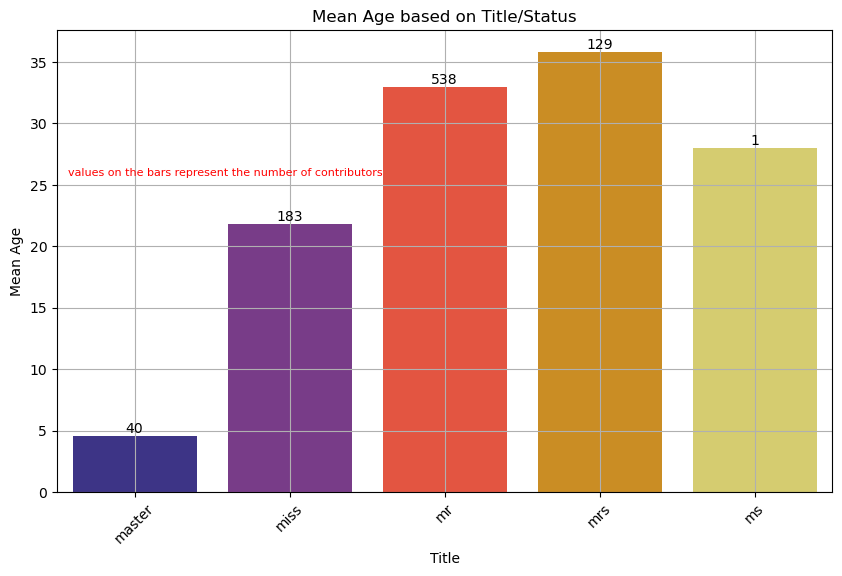

In [13]:
#Facem un barplot ca sa vizualizam concret media in functie de statut
plt.figure(figsize=(10, 6))
sns.barplot(data = df_mean_age_count, x = df_mean_age_count["Title"], y = df_mean_age_count["Mean_Age"], palette = 'CMRmap')

#Punem valoriile de count deasupra fiecarei coloane ca sa observam si mai bine numarul de contribuitori ai mediilor
for index, row in df_mean_age_count.iterrows():
    plt.text(index, row["Mean_Age"], str(row["Mean_contributors"]), ha='center', va='bottom')

plt.xlabel("Title")
plt.ylabel("Mean Age")
plt.title("Mean Age based on Title/Status")
plt.grid()
plt.xticks(rotation = 45)

#Adaug o legenda 
plt.text(0.6, 26, "values on the bars represent the number of contributors ", ha='center', va='center', fontsize=8, color='red')

plt.show()

-  Urmatorul pas este, pentru categoriile care au mai mult de 20-30 de elemente, sa vizualizam histogramele. Ar ajuta sa vedem ce distributie urmaresc aceste varste si, in functie de asta, daca este normal, skewed to the left / right, sa decim ce valori punem.

-  De asemenea, ar fi important sa vizualizam si boxploturi sa vedem daca avem outliere sau nu.

###### Pentru Master

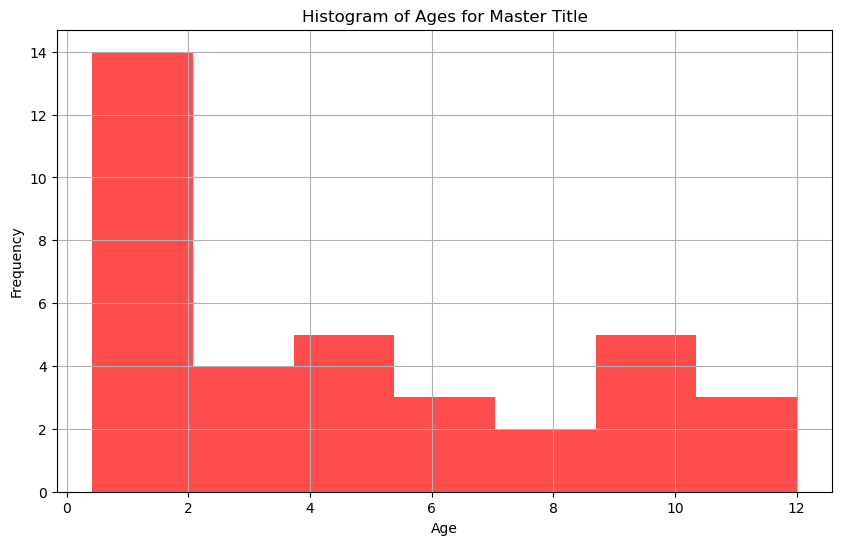

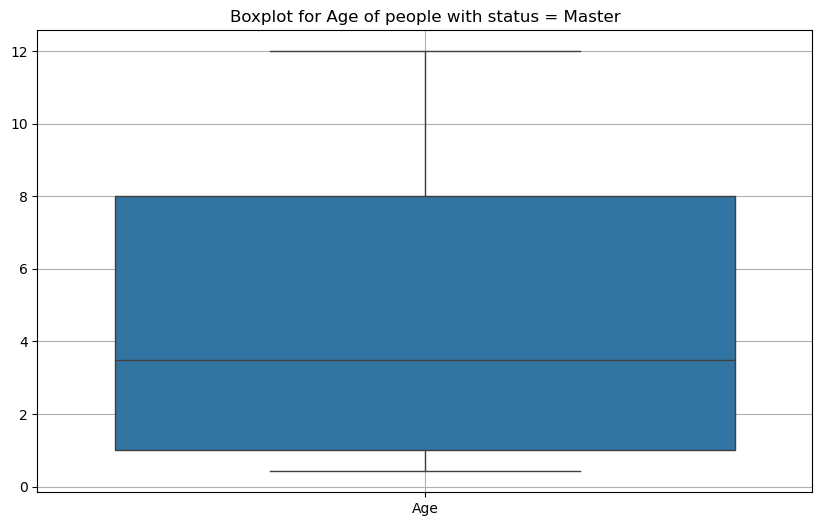

In [14]:
#Facem filtrul pentru a filtra dataframeul pentru a obtine doar varstele celor cu titlul Master
mask_age_master = ((df["Title"] == "master") & (df["Age"].notnull()))
df_hist_master = df[mask_age_master]

#Calculam numarul optim de binuri
nr_bins_master = int(np.floor(np.sqrt(df_hist_master["Age"].count())) + 1)


#Generam histograma pe setul filtrat
plt.figure(figsize=(10, 6))
plt.hist(data=df_hist_master, x="Age", bins=nr_bins_master, color="red", alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Ages for Master Title")
plt.grid()

plt.show()

#Generam boxplot cu varstele celor cu titlu = Master
plt.figure(figsize=(10, 6))
sns.boxplot(df_hist_master["Age"].reset_index().drop(columns = "index"))

plt.title("Boxplot for Age of people with status = Master")
plt.grid()

plt.show()

- Observam ca distributia varstei pentru cei cu titlul de Master este skewed to the right. Ce e important este ca nu avem outliere, ceea ce inseamna ca valoriile de  null vor putea fi inlocuite cu media (daca aveam outliere, le inlocuiam cu medianul). 
- Mentionez ca ideea in sine de outlier are sens in acest context, intrucat Master se aplica pentru copiii intre 0-18 ani. Este gresit sa ai acest statut dupa varsta de 18 ani (cred, poate imi confirm acest lucru daca vad cati sunt Master / pclass, intrucat Master poate sa fie copil de bani gata cum ar veni)

###### Pentru MIss

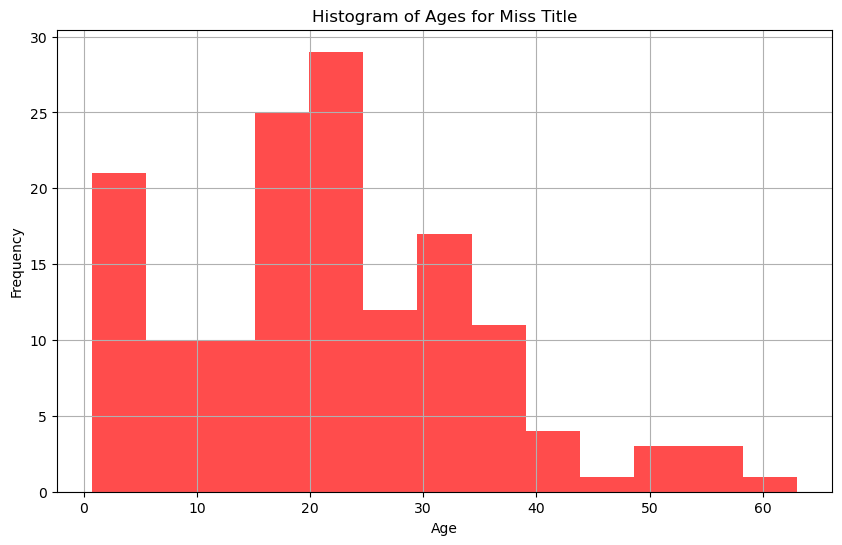

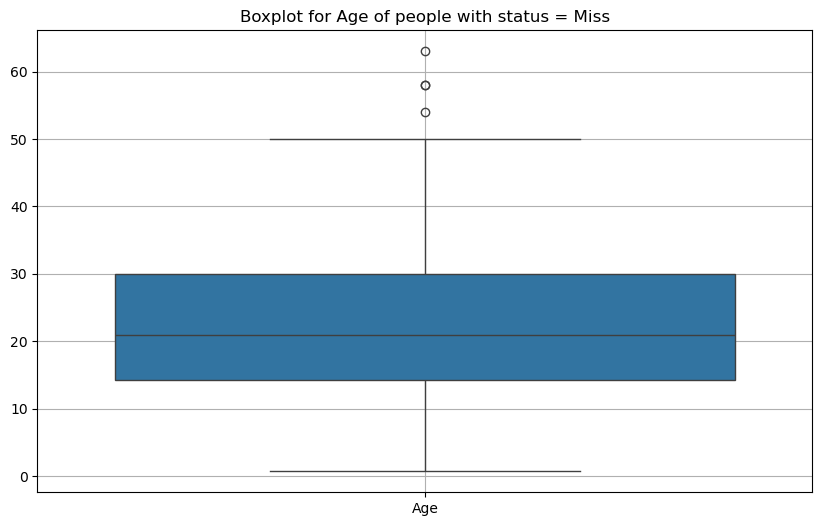

In [15]:
#Facem filtrul pentru a filtra dataframeul pentru a obtine doar varstele celor cu titlul Master
mask_age_miss = ((df["Title"] == "miss") & (df["Age"].notnull()))
df_hist_miss = df[mask_age_miss]

#Calculam numarul optim de binuri
nr_bins_miss = int(np.floor(np.sqrt(df_hist_miss["Age"].count())) + 1)


#Generam histograma pe setul filtrat
plt.figure(figsize=(10, 6))
plt.hist(data=df_hist_miss, x="Age", bins=nr_bins_miss, color="red", alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Ages for Miss Title")
plt.grid()

plt.show()

#Generam boxplot cu varstele celor cu titlu = Master
plt.figure(figsize=(10, 6))
sns.boxplot(df_hist_miss["Age"].reset_index().drop(columns = "index"))

plt.title("Boxplot for Age of people with status = Miss")
plt.grid()

plt.show()

- Daca am inteles bine, MIss. se foloseste pentru femei <= 30 de ani si NEMARITATE. Asta inseamna ca, pentru 25% din femei dupa cum se vede in boxplot, ar trebui schimbat titlul ori in Mrs (femeie maritata), ori in Ms (femeieis nemaritata si peste 30 SAU dacă preferă să fie adresată cu un titlu neutru din punct de vedere civil)

- Raportat la ce valori punem la varsta, mai intai trebuie sa modificam statutul pentru femeile > 30 de ani si dupa sa recalculam media. Dupa aceea, valoriile de Nan vor lua noua medie calculata

##### Am realizat ca trebuie sa mai fac o coloana, unde sa vad daca si-au schimbat numele sau nu ( ca sa vad daca au fost maritate). Informatia este furnizata direct in nume (dupa numele acestora este scris in paranteza numele vechi). De mentionat ca numele din paranteza poate sa fie si porecla.

In [16]:
import re

def extract_text_in_parentheses(text):
    
    '''
    Functia are rolul de a extragere numele vechi al persoanei.
    '''
    
    # Define a regular expression pattern to match text within parentheses
    pattern = r'\((.*?)\)'
    
    # Use re.findall to find all matches of the pattern in the text
    matches = re.findall(pattern, text)
    
    # Return the first match found (if any)
    if matches:
        return matches[0]
    else:
        return None

# Example usage
df["Previous_name"] = df["Name"].apply(extract_text_in_parentheses)


In [17]:
#hai sa vad fetele copile cum sunt
mask = (df["Age"] < 18) & (df["Sex"] == 1)
df[mask]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Previous_name
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.00,1,0,237736,30.0708,1,mrs,Adele Achem
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.00,1,1,PP 9549,16.7000,0,miss,None
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",1,14.00,0,0,350406,7.8542,0,miss,None
22,23,1,3,"McGowan, Miss. Anna ""Annie""",1,15.00,0,0,330923,8.0292,2,miss,None
24,25,0,3,"Palsson, Miss. Torborg Danira",1,8.00,3,1,349909,21.0750,0,miss,None
39,40,1,3,"Nicola-Yarred, Miss. Jamila",1,14.00,1,0,2651,11.2417,1,miss,None
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",1,3.00,1,2,SC/Paris 2123,41.5792,1,miss,None
58,59,1,2,"West, Miss. Constance Mirium",1,5.00,1,2,C.A. 34651,27.7500,0,miss,None
68,69,1,3,"Andersson, Miss. Erna Alexandra",1,17.00,4,2,3101281,7.9250,0,miss,None
71,72,0,3,"Goodwin, Miss. Lillian Amy",1,16.00,5,2,CA 2144,46.9000,0,miss,None


In [18]:
# Dupa cum observam, avem 3 cazuri care sa respecte conditia de mai jos. Nu pare ca trebuie modificat ceva

mask_for_miss_married = (
    (df["Title"] == "miss") & (df["Age"].notnull()) &
    ((df["Age"] < 30)) &
    (df["Previous_name"].notnull())
)
df[mask_for_miss_married]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Previous_name
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",1,24.0,0,0,248747,13.0000,0,miss,"""Mrs Harbeck"""
381,382,1,3,"Nakid, Miss. Maria (""Mary"")",1,1.0,0,2,2653,15.7417,1,miss,"""Mary"""
427,428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",1,19.0,0,0,250655,26.0000,0,miss,"""Mrs Kate Louise Phillips Marshall"""


In [19]:
#La fel, verificam femeile peste 30 de ani care sunt miss SI care au numele schimbat -> vor deveni mrs
mask_for_miss_married = (
    (df["Title"] == "miss") & (df["Age"].notnull()) &
    (df["Age"] >= 30) &
    (df["Previous_name"].notnull())
)
df[mask_for_miss_married]

# Observam ca nu exista nici un caz de tipul asta

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Previous_name


In [20]:
#Mai ramane sa vedem femeile peste 30 de ani care sunt miss SI care NU au numele schimbat
mask_for_miss_married = (
    (df["Title"] == "miss") & (df["Age"].notnull()) &
    (df["Age"] >= 30) &
    (df["Previous_name"].isnull())
)
df[mask_for_miss_married]

# Le fac Ms. din moment ce au peste 30 de ani si nu sunt maritate
df.loc[mask_for_miss_married, "Title"] = "ms"

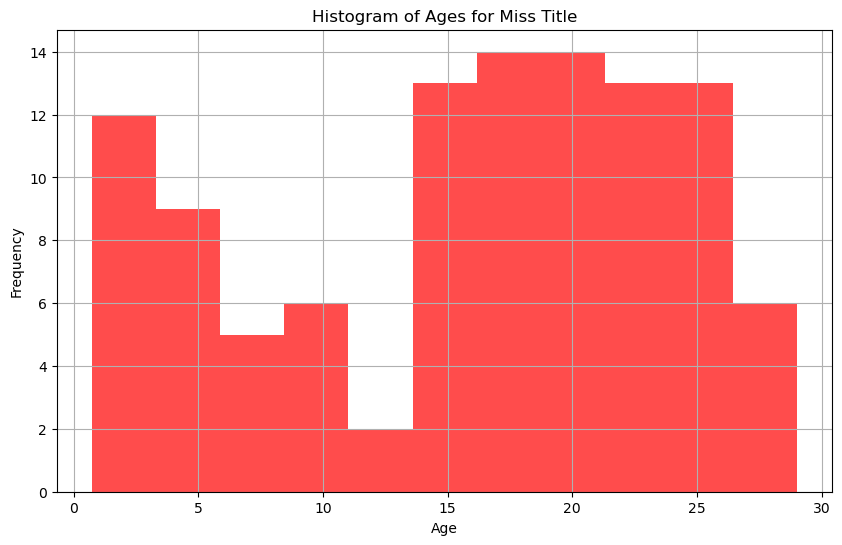

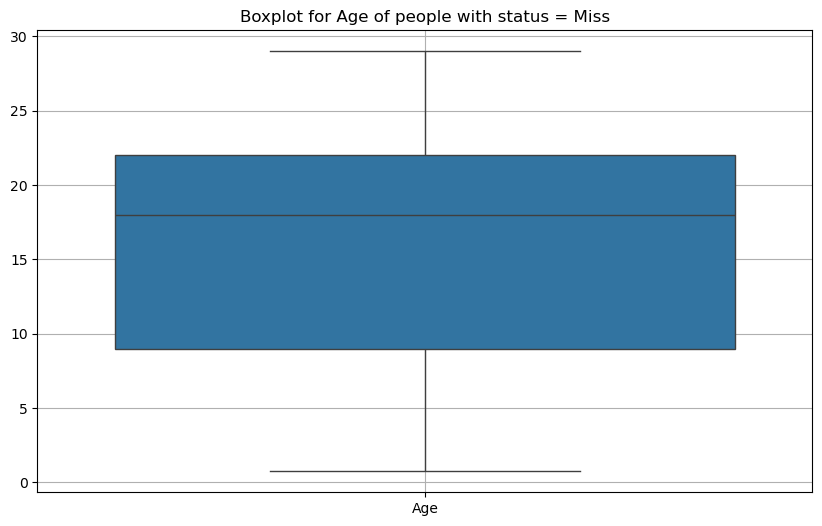

In [21]:
#Facem filtrul pentru a filtra dataframeul pentru a obtine doar varstele celor cu titlul Master
mask_age_miss = ((df["Title"] == "miss") & (df["Age"].notnull()))
df_hist_miss = df[mask_age_miss]

#Calculam numarul optim de binuri
nr_bins_miss = int(np.floor(np.sqrt(df_hist_miss["Age"].count())) + 1)


#Generam histograma pe setul filtrat
plt.figure(figsize=(10, 6))
plt.hist(data=df_hist_miss, x="Age", bins=nr_bins_miss, color="red", alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Ages for Miss Title")
plt.grid()

plt.show()

#Generam boxplot cu varstele celor cu titlu = Master
plt.figure(figsize=(10, 6))
sns.boxplot(df_hist_miss["Age"].reset_index().drop(columns = "index"))

plt.title("Boxplot for Age of people with status = Miss")
plt.grid()

plt.show()

-  Acum ca vad histograma, ma gandesc ca ar avea mai mult sens ca fetele de 12 ani sa primeasca alta porecla (cum e la baieti Master). Asadar, o sa pun la fetele sub 12 ani Master_girl.

In [22]:
mask_age_miss = ((df["Title"] == "miss") & (df["Age"].notnull()) & (df["Age"] <= 12))
df.loc[mask_age_miss, "Title"] = "master_girl"

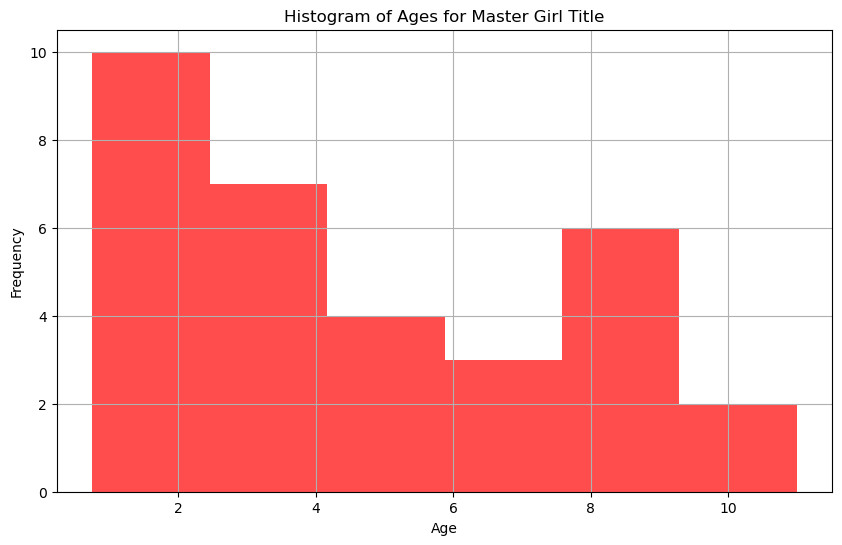

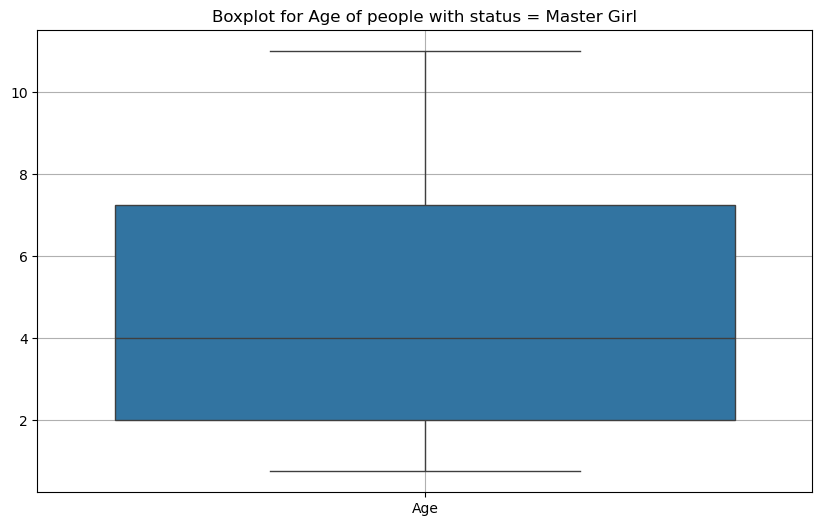

In [23]:
#Facem filtrul pentru a filtra dataframeul pentru a obtine doar varstele celor cu titlul Master
mask_age_master_girl = ((df["Title"] == "master_girl") & (df["Age"].notnull()))
df_hist_master_girl = df[mask_age_master_girl]

#Calculam numarul optim de binuri
nr_bins_girl = int(np.floor(np.sqrt(df_hist_master_girl["Age"].count())) + 1)


#Generam histograma pe setul filtrat
plt.figure(figsize=(10, 6))
plt.hist(data=df_hist_master_girl, x="Age", bins=nr_bins_girl, color="red", alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Ages for Master Girl Title")
plt.grid()

plt.show()

#Generam boxplot cu varstele celor cu titlu = Master
plt.figure(figsize=(10, 6))
sns.boxplot(df_hist_master_girl["Age"].reset_index().drop(columns = "index"))

plt.title("Boxplot for Age of people with status = Master Girl")
plt.grid()

plt.show()

###### Pentru Mr

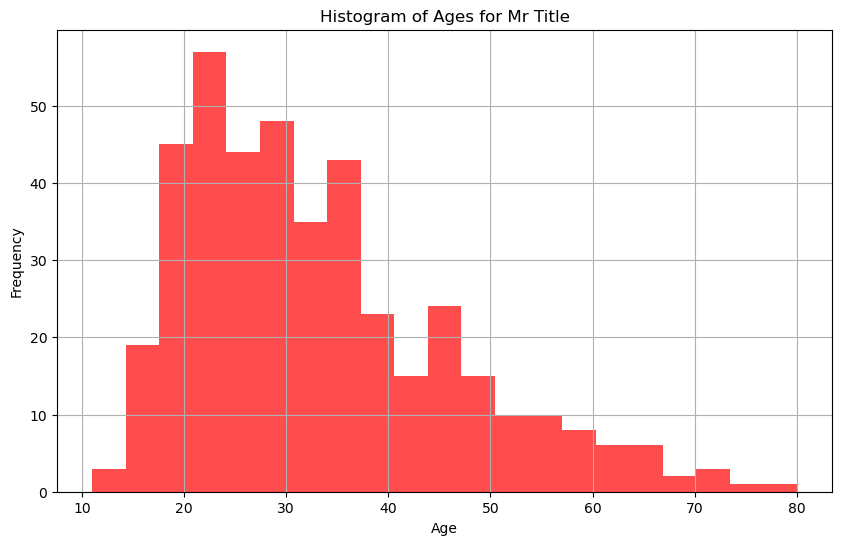

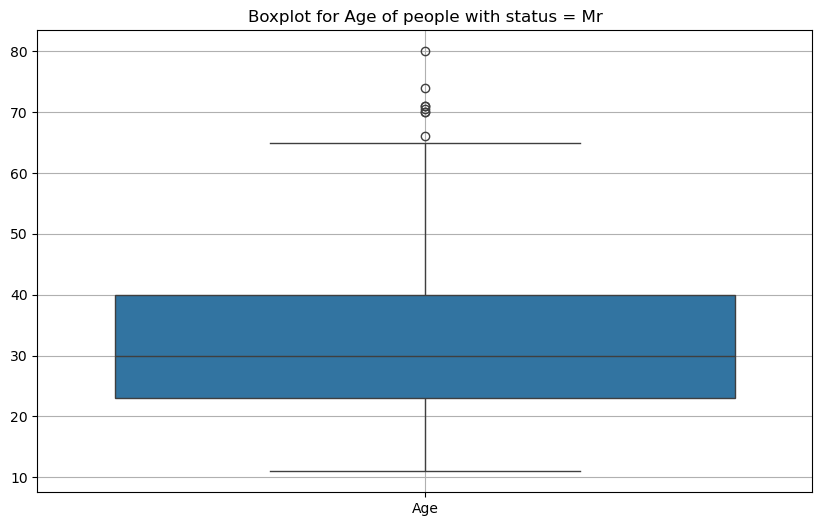

In [24]:
#Facem filtrul pentru a filtra dataframeul pentru a obtine doar varstele celor cu titlul Master
mask_age_mr = ((df["Title"] == "mr") & (df["Age"].notnull()))
df_hist_mr = df[mask_age_mr]

#Calculam numarul optim de binuri
nr_bins_mr = int(np.floor(np.sqrt(df_hist_mr["Age"].count())) + 1)


#Generam histograma pe setul filtrat
plt.figure(figsize=(10, 6))
plt.hist(data=df_hist_mr, x="Age", bins=nr_bins_mr, color="red", alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Ages for Mr Title")
plt.grid()

plt.show()

#Generam boxplot cu varstele celor cu titlu = Master
plt.figure(figsize=(10, 6))
sns.boxplot(df_hist_mr["Age"].reset_index().drop(columns = "index"))

plt.title("Boxplot for Age of people with status = Mr")
plt.grid()

plt.show()

In [25]:
#Exact la fel, cei sub 12 ani ii facem Master
mask_age_mr = ((df["Title"] == "mr") & (df["Age"].notnull()) & (df["Age"] <= 12))
df.loc[mask_age_mr, "Title"] = "master"

In [26]:
#Hai sa observam outlierele alea
mask_for_old_mr = (df["Title"] == "mr") & (df["Age"] >= 60)
df[mask_for_old_mr]

#Observam ca pasagerul cu PassanerId 631 este viu, cand nu ar trebui. Modificam statusul supravieturii
df.loc[630, "Survived"] = 0

In [27]:
df_mean_age_after = round(df["Age"].groupby(df["Title"]).mean(), 1).reset_index().set_index("Title")
df_mean_age_after

df_mean_ages = df_mean_age_after.merge(df_mean_age_initial, how = "left", on = "Title")
print(df_mean_ages)

#OBSERVAM CA NU S-AU SCHIMBAT MULT, DAR AR FI INTERESANT DE VAZUT NUMARUL LOR CUM S-A MODIFICAT (COUNT)

df_mean_count_after = df["Title"].value_counts().reset_index()

df_mean_count_after =df_mean_count_after.merge(df_count_initial, how = 'left', on = "Title")
print(df_mean_count_after)

         Title   Age  Mean_Age
0       master   4.7       4.6
1  master_girl   4.8       NaN
2         miss  20.4      21.8
3           mr  33.1      33.0
4          mrs  35.8      35.8
5           ms  37.7      28.0
         Title  count  Mean_contributors
0           mr    537              538.0
1          mrs    129              129.0
2         miss    111              183.0
3       master     41               40.0
4           ms     41                1.0
5  master_girl     32                NaN


In [28]:
# PAS3 : Modificam valoriile NaN cu mediile de varsta pentru fiecare statut social
mask_age = df["Age"].isnull()   #conditia dupa care filtram dataframe-ul

df.loc[mask_age, "Age"] = df.loc[mask_age,"Title"].map(df_mean_age_after["Age"])   # modificam valoriile NaN cu mediile calculate anterior

In [29]:
#renuntam la coloana provizorie previous_name + convertim titlurile in numere 
df = df.drop(columns = ["Previous_name"])


title_mapping = {
    "miss": 1, "master": 2, "mr": 3, "mrs": 4, "ms": 5 , "master_girl": 6
}

# Assuming your DataFrame column is named "Title"
df["Title_number"] = df["Title"].map(title_mapping)

In [30]:
df.info() # Setul nu mai are valori de null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    int64  
 5   Age           891 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Embarked      891 non-null    int64  
 11  Title         891 non-null    object 
 12  Title_number  891 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 90.6+ KB


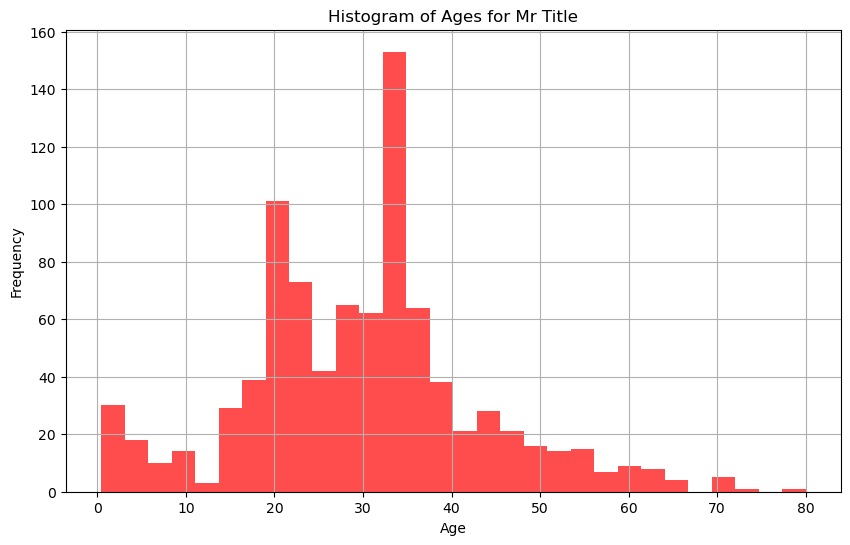

In [31]:
# Ultimul pas este sa vedem distributia varstei ca sa vedem daca e aproximativ normala

#Calculam numarul optim de binuri
nr_bins_age = int(np.floor(np.sqrt(df["Age"].count())) + 1)

#Generam histograma pe setul filtrat
plt.figure(figsize=(10, 6))
plt.hist(data=df, x="Age", bins=nr_bins_age, color="red", alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Ages for Mr Title")
plt.grid()


- Arata bine distributia.

# Am terminat cu completarea nululilor, urmeaza sa analizam setul de date.

### COLOANE CU VALORI DISCRETE

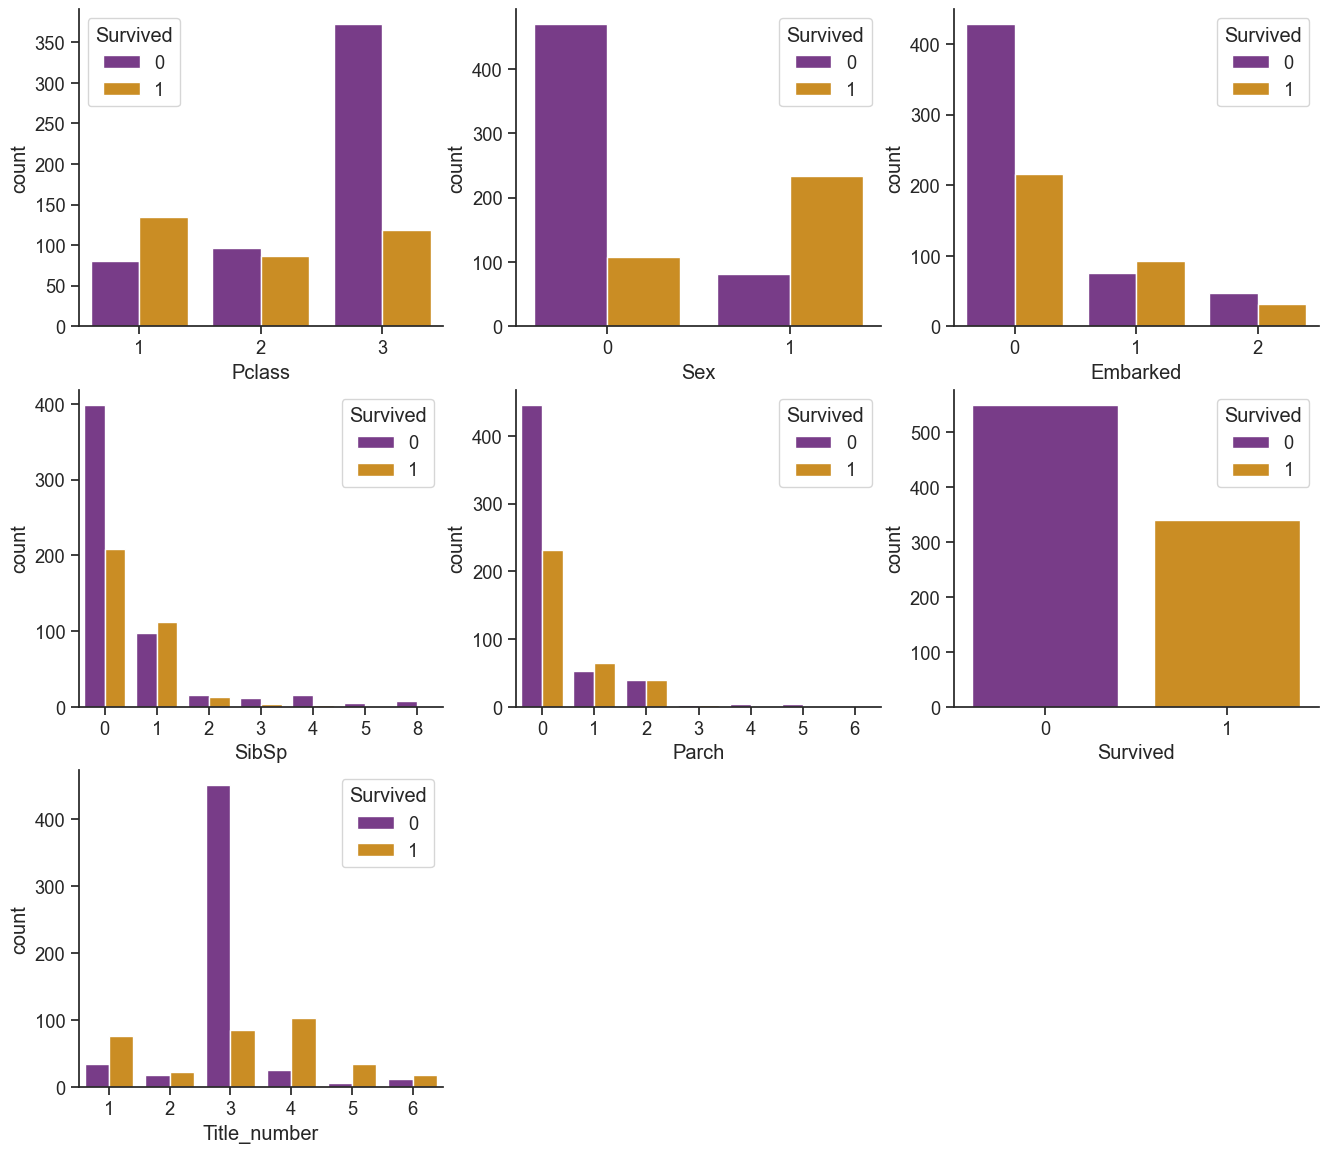

In [32]:
# Ma intereseaza sa vad coloane care au date de tip discret ca sa vad cum supravietuiesc oamenii in functie de clase

coloane_discrete = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived','Title_number']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(coloane_discrete):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=feature, hue='Survived', palette = 'CMRmap')
    
sns.despine()


#Title number mai bine il vedem separat, intrucat nu se vede asa bine


### OBS:
    1. Setul nu este echilibrat ( mai multi oameni au murit decat supravietuit)
    2. Femeile au avut sanse mai mari de supravietuire.
    3. Locul Imbarcatiunii este inselator, in sensul ca, din cauza ca s-au urcat mai multi oameni n portul 0, impresia ca sansa de supravietuire pentru cei care s-au imbarcat in acel port a fost mai mica nu e neaparat corecta.
    4. Cei care au avut rude au avut sansa mai mare de supravietuire.
    5. Familia este extrem de importanta aparent: cu cati mai multi membrii, cu atat a fost sansa mai mare de supravietuire. -> Facem coloana Family separat
    5. Ultimul grafic trebuie vizualizat separat

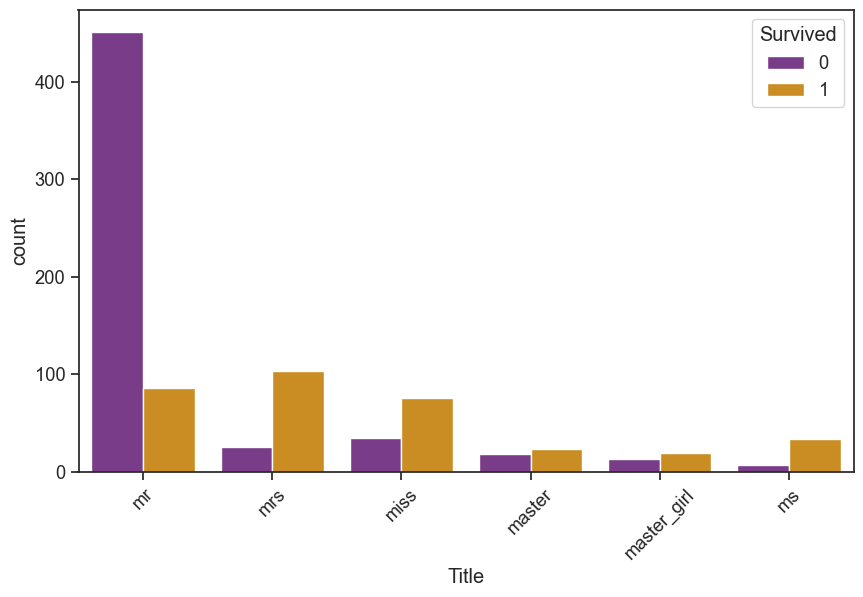

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['Title'], hue='Survived', palette='CMRmap')
plt.xticks(rotation=45)
plt.show()

### Obs:
    1. femeile (miss, mrs, ms) si copiii (master, master_girl) au un procent de supravietuire mai mare de 50% =>
   #####       poate ar trebui sa fac o coloana separata cu informatia asta ?
    2. barbatii au murit in proportii uriase

In [34]:
#momentan pica ideea asta pana imi dau seama cum sa o conectez cu family
'''
#Mai facem o coloana unde verificam daca persoana e femeie / copil de tipul 0 sau 1
woman_child = ["mrs", "miss", "master", "master_girl", "ms"]

for i in range(len(df)):
    if df.loc[i, "Title"] in woman_child:
        df.loc[i, "Woman/Child"] = 1
    else:
        df.loc[i, "Woman/Child"] = 0

#Vizualizam
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['Woman/Child'], hue='Survived', palette='CMRmap')
plt.xticks(rotation=45)
plt.show()
'''

'\n#Mai facem o coloana unde verificam daca persoana e femeie / copil de tipul 0 sau 1\nwoman_child = ["mrs", "miss", "master", "master_girl", "ms"]\n\nfor i in range(len(df)):\n    if df.loc[i, "Title"] in woman_child:\n        df.loc[i, "Woman/Child"] = 1\n    else:\n        df.loc[i, "Woman/Child"] = 0\n\n#Vizualizam\nplt.figure(figsize=(10, 6))\nsns.countplot(data=df, x=df[\'Woman/Child\'], hue=\'Survived\', palette=\'CMRmap\')\nplt.xticks(rotation=45)\nplt.show()\n'

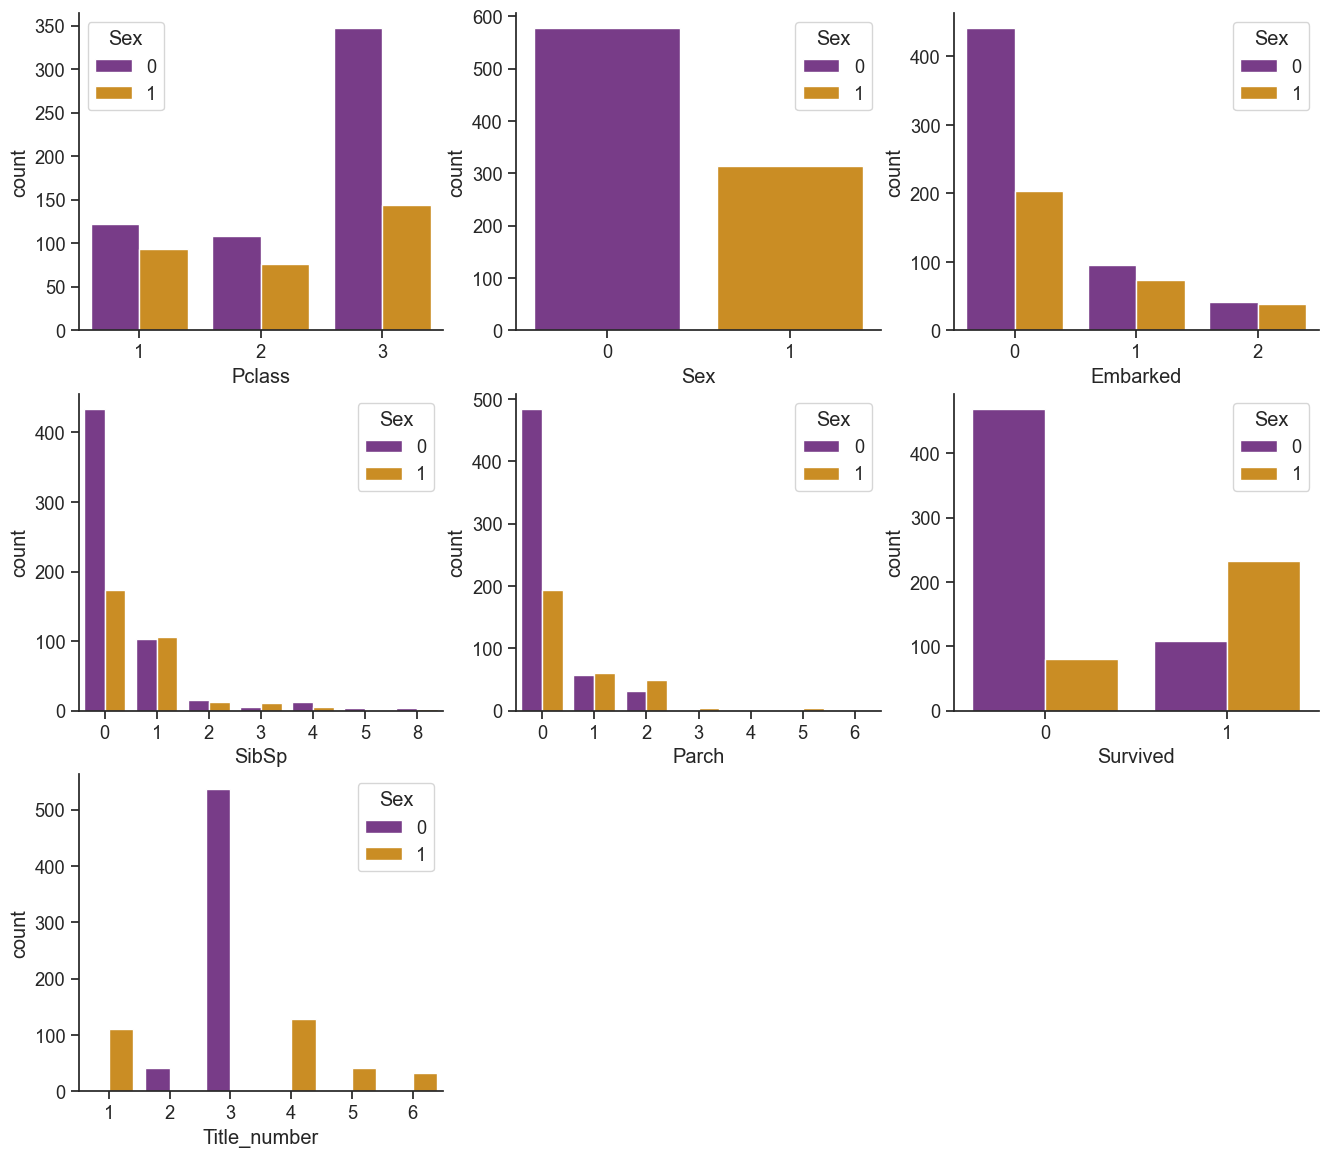

In [35]:
# De data asta vreau sa vad coloanele  care au date de tip discret in functie de sex

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(coloane_discrete):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=feature, hue='Sex', palette='CMRmap')
    
sns.despine()


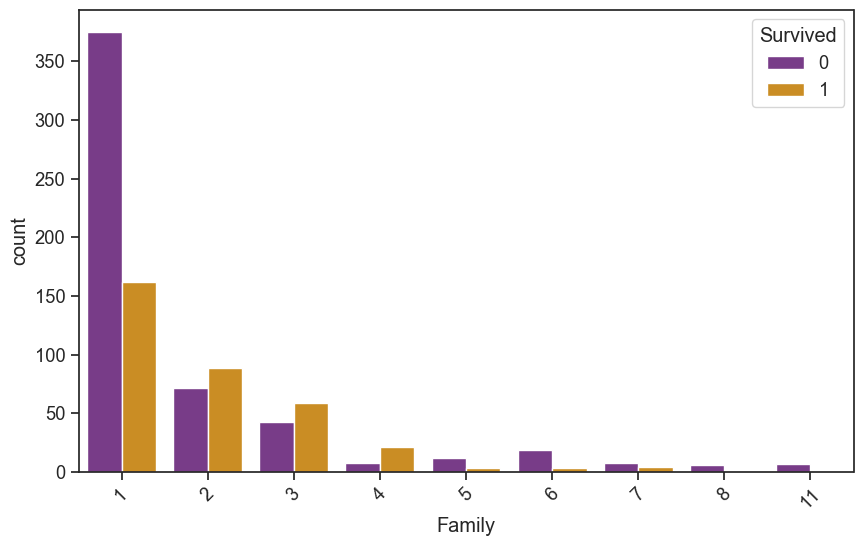

In [36]:
#Facem coloana Family in care adunam SibSp + Parch
df["Family"] = df["SibSp"] + df["Parch"]

# Am realizat ca o familie nu are cum sa aiba 0 membrii, asa ca adaug +1
df["Family"] = df["Family"] + 1

#Vizualizam nr de supravietuitori in functie de numarul de membrii
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['Family'], hue='Survived', palette='CMRmap')
plt.xticks(rotation=45)
plt.show()

- AVEM: o coloana unde avem numarul de membrii SI o coloana unde avem daca persoana e copil sau femeie
- Stim ca daca persoana e femeie / copil are sanse mai mari
- Cel mai probabil, daca avem o femeie si are un copil, sanse ei cresc

### Observ ca familile au un numar diversificat de membrii, asa ca ii bag pe categorii:
- 1 membru : singur                 punem 0
- 2 - 3 membrii : familie mica      punem 1
- 4 - 5 membrii : familie mare      punem 2
- 6 - 11 membrii: familie uriasa    punem 3

In [37]:
df.loc[df["Family"] == 1, "Family"] = 0
df.loc[(df["Family"] >= 2) & (df["Family"] <=3), "Family"] = 1
df.loc[(df["Family"] >= 4) & (df["Family"] <=5), "Family"] = 2
df.loc[(df["Family"] >= 6) & (df["Family"] <=11), "Family"] = 3

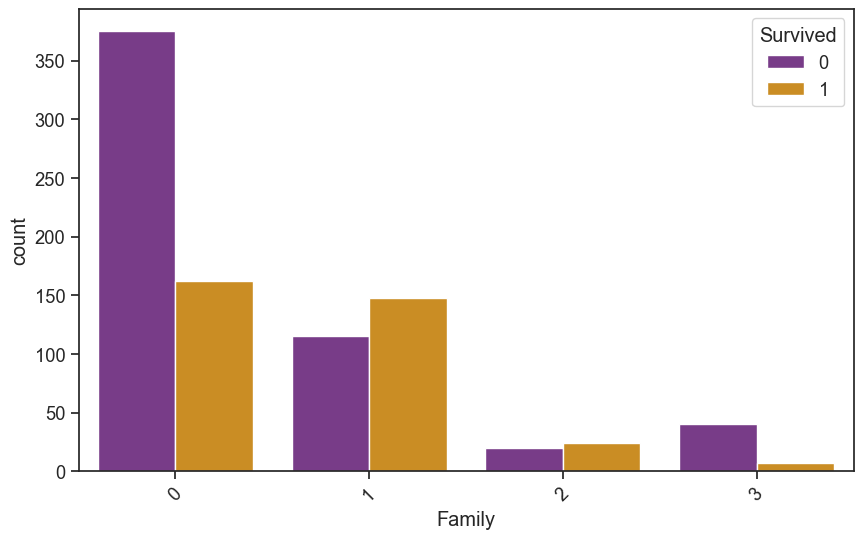

In [38]:
# Mai vizualizam o data  nr de supravietuitori in functie de numarul de membrii
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['Family'], hue='Survived', palette='CMRmap')
plt.xticks(rotation=45)
plt.show()

In [43]:
columns = ["Pclass", "Sex", "Title_number", "Embarked",  "Fare", "Family"]
X = df[columns]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=7)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.835820895522388


C:\Users\sbula\AppData\Local\Temp\ipykernel_38996\4236707292.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances",


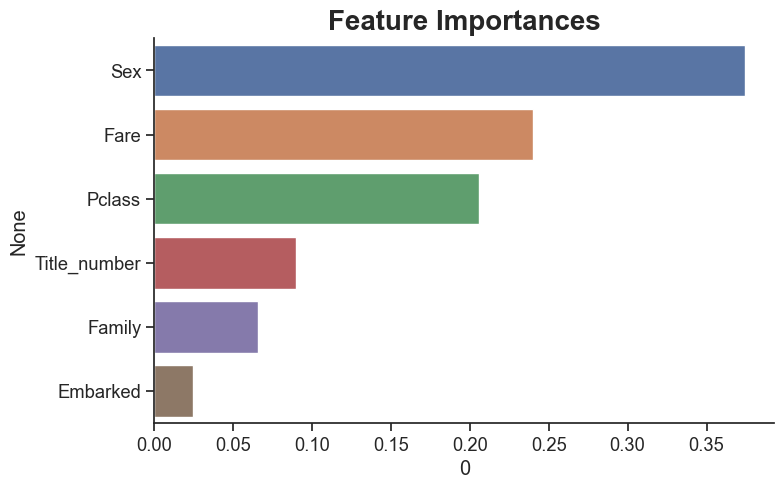

In [40]:
importances = pd.DataFrame(clf.feature_importances_, index = columns)
importances.sort_values(by = 0, inplace=True, ascending = False)
importances = importances.iloc[0:6,:] 

plt.figure(figsize=(8, 5)) 
sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances",
                                                                                 fontdict= { 'fontsize': 20,
                                                                                            'fontweight':'bold'});
sns.despine()